# INF-0616 - Projeto 3: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- a229999@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina:
[moodle.lab.ic.unicamp.br/469](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=469)

Instituto de Computação - Unicamp 2022

**Nome dos membros do grupo**:
- Leonardo Cesar Silva dos Santos
- Fernando Augusto Cardoso Candalaft

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun May  5 12:15:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [4]:
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [5]:
# data_path = "./customer-issues.csv"
data_path = "/content/drive/MyDrive/Colab Notebooks/mdc/06_aprendizado_supervisionado_II_inf_0616/test03/customer-issues.csv"
d = pd.read_csv(data_path)

display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


In [6]:

d.shape

(199970, 14)

##### Exibindo as quatro primeiras mensagens

In [7]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [8]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [9]:
plt.style.use('ggplot')

def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    (sns
     .barplot(x=[l[:40] for l in labels], y=counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)

    return labels, counts

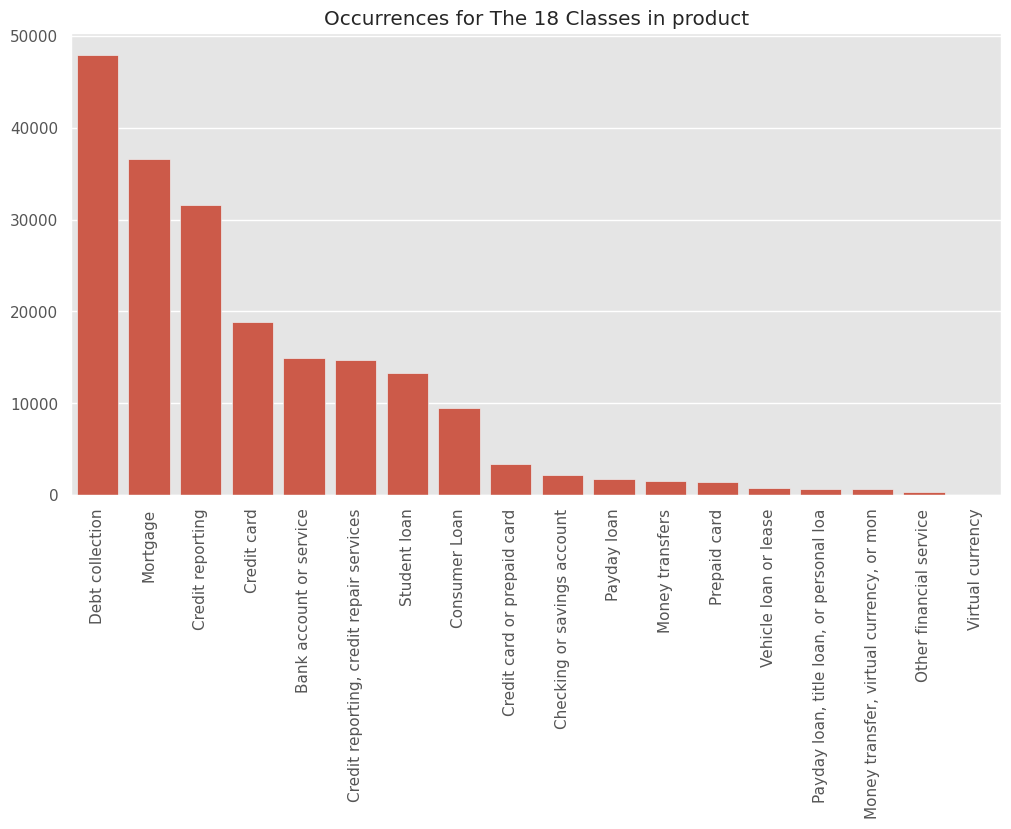

In [10]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [11]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
type(x_train)

scipy.sparse._csr.csr_matrix

In [15]:
x_train.shape, np.unique(ye_train)

((115143, 1024), array([0, 1, 2, 3, 4, 5]))

In [16]:
penalties = ["l1", "l2"]
C_range = np.logspace(-2, 2, 5)

param_grid = dict(C=C_range, penalty=penalties)
param_grid

{'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'penalty': ['l1', 'l2']}

In [17]:
lr_test = LogisticRegression(multi_class="multinomial",
                             max_iter=100,
                             class_weight="balanced")

lr_test.fit(x_train, ye_train)
np.unique( lr_test.predict(x_train) )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 1, 2, 3, 4, 5])

In [18]:
# Definindo o modelo no qual iremos aplicar o GridSearch
lr = LogisticRegression(multi_class="multinomial",
                        max_iter=100,
                        class_weight="balanced")

In [19]:
import os

os.cpu_count()

n_jobs = os.cpu_count() # - 2
n_jobs

2

In [20]:
grid = GridSearchCV(lr,
                    param_grid,
                    cv=5,
                    scoring="balanced_accuracy",
                    verbose=1,
                    n_jobs=n_jobs)

grid.fit(x_train, ye_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          multi_class='multinomial'),
             n_jobs=2,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='balanced_accuracy', verbose=1)

In [21]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7512974546094726
{'C': 0.01, 'penalty': 'l2'}
LogisticRegression(C=0.01, class_weight='balanced', multi_class='multinomial')


In [22]:
# Treinando o melhor modelo encontrado
lr = LogisticRegression(C=0.01, penalty="l2",
                        class_weight="balanced",
                        multi_class="multinomial",
                        max_iter=100)
lr.fit(x_train, ye_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, class_weight='balanced', multi_class='multinomial')

Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [35]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)

    # Impressão dos gráficos.
    (plt
     .figure(figsize=(12, 9))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(12, 9))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))

    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])
    plt.legend(labels)

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

In [36]:
label_enc.classes_

array(['Bank account or service', 'Credit card', 'Credit reporting',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Mortgage'], dtype=object)

In [37]:
import warnings
warnings.filterwarnings('ignore')

Accuracy: 0.754
Accuracy (balanced): 0.748


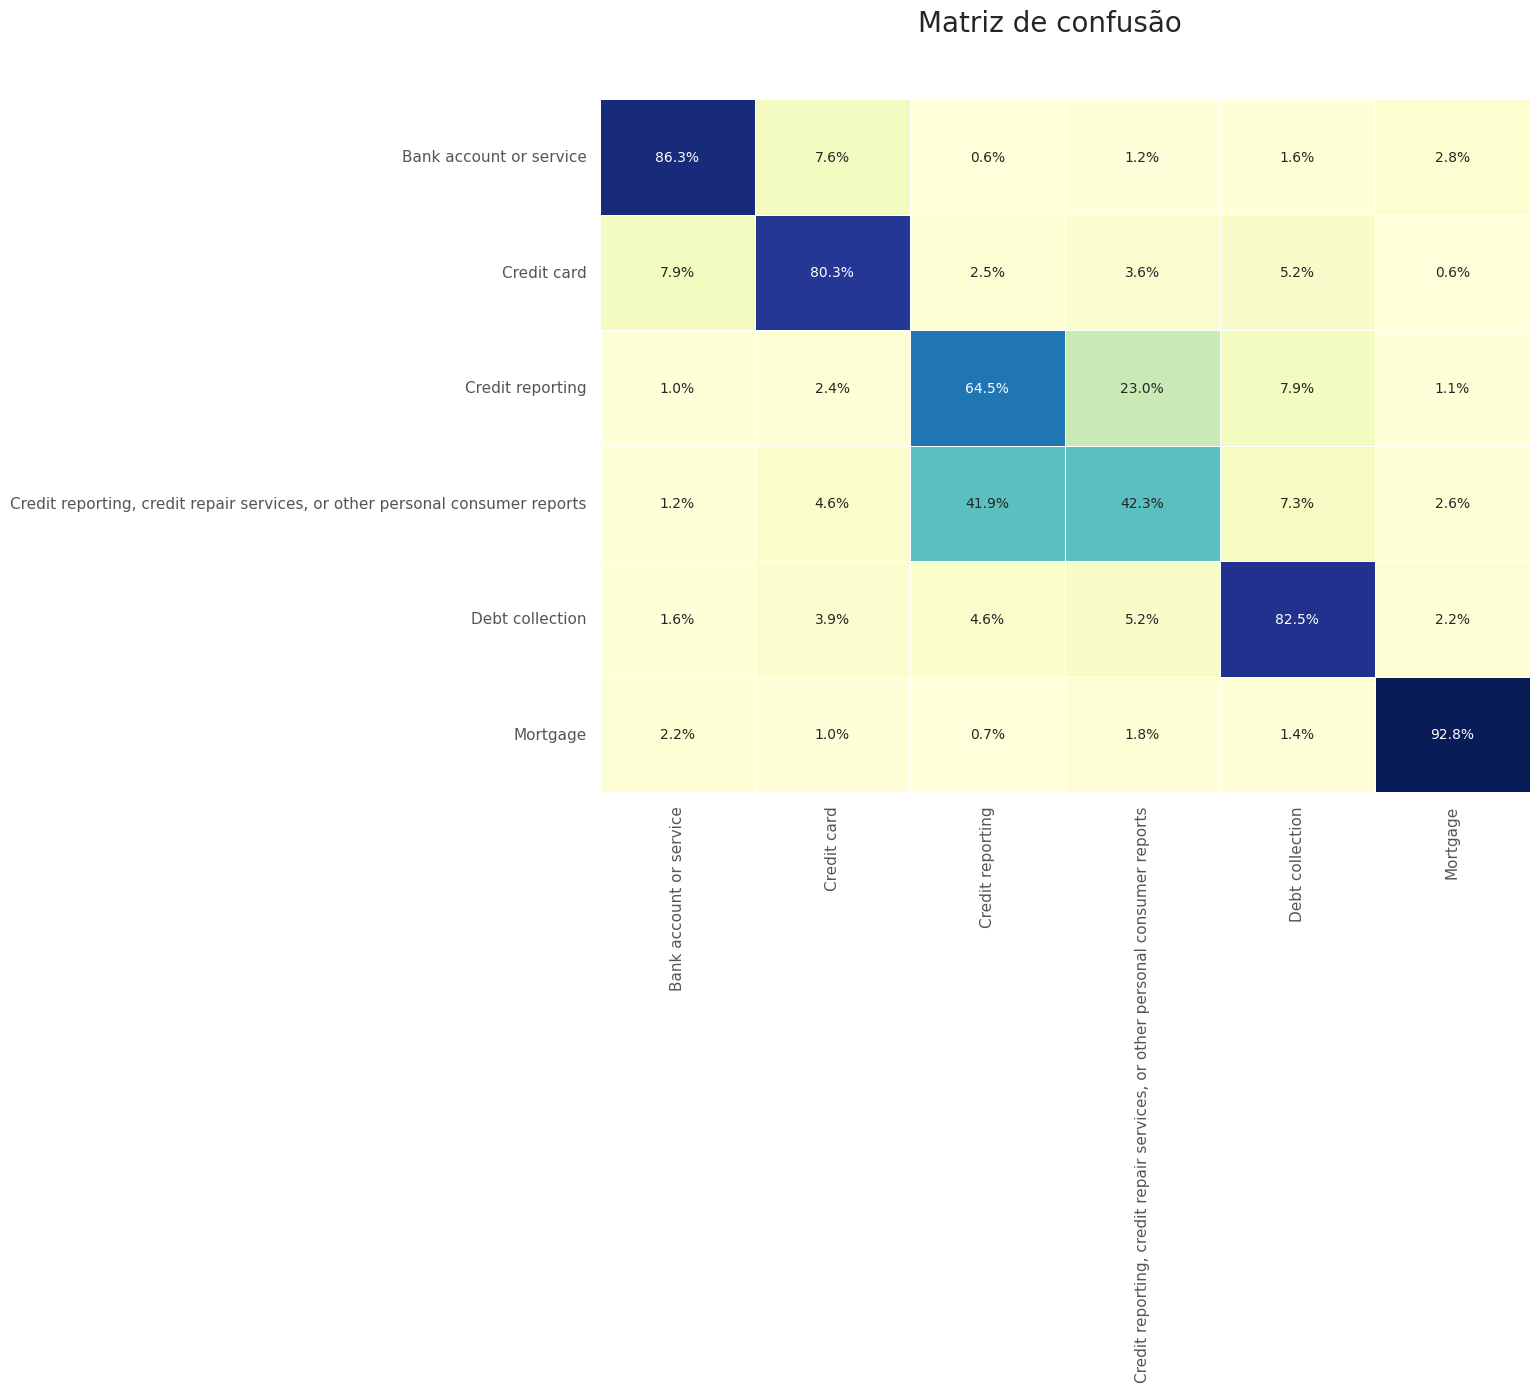

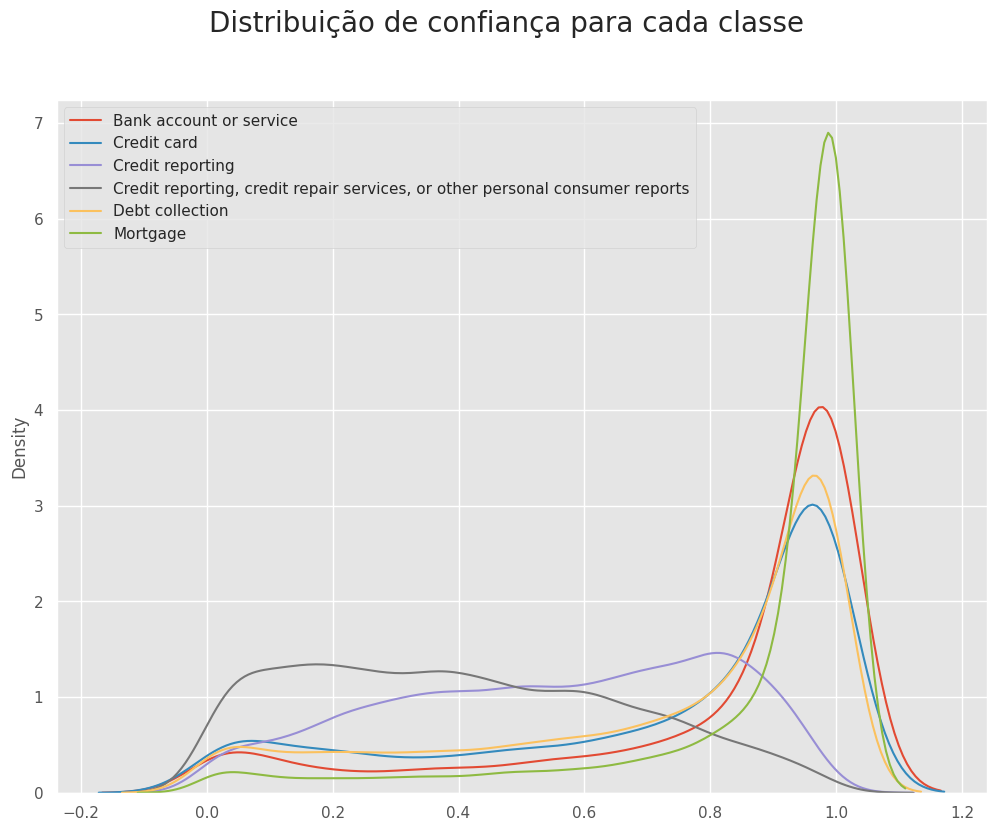

In [38]:
evaluate(ye_test,
         lr.predict(x_test),
         lr.predict_proba(x_test),
         labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

**Há uma diferença mais significativa no nível de confiança das classes 'Credit reporting' e 'Credit reporting, credit repair services, or other personal consumer reports' com relação às outras, sendo que estas duas classes possuem um baixo nível de confiança com relação aos seus valores preditos. Já as outras classes ('Bank account or service', 'Credit card', 'Debt collection', 'Mortgage') possuem um alto nível de confiança.**

**O baixo nível de confiança da classe 'Credit reporting, credit repair services, or other personal consumer reports' pode estar relacionado à baixa quantidade de exemplos da mesma durante o treinamento do modelo. Já o baixo nível da classe 'Credit reporting' pode estar relacionado a alguma dificuldade do modelo em identificar uma separação clara desta classe com relação às outras, principalmente em casos que parece haver uma intersecção de classes, como as duas citadas aqui.**

In [39]:
label_enc.classes_

array(['Bank account or service', 'Credit card', 'Credit reporting',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Mortgage'], dtype=object)

In [40]:
unique, counts = np.unique(ye_test, return_counts=True)
print(np.asarray((unique, counts, label_enc.classes_)).T)

[[0 4058 'Bank account or service']
 [1 4902 'Credit card']
 [2 8604 'Credit reporting']
 [3 7620
  'Credit reporting, credit repair services, or other personal consumer reports']
 [4 13884 'Debt collection']
 [5 10279 'Mortgage']]


In [41]:
unique, counts = np.unique(ye_train, return_counts=True)
print(np.asarray((unique, counts, label_enc.classes_)).T)

[[0 10830 'Bank account or service']
 [1 13940 'Credit card']
 [2 22988 'Credit reporting']
 [3 7051
  'Credit reporting, credit repair services, or other personal consumer reports']
 [4 34031 'Debt collection']
 [5 26303 'Mortgage']]


----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [42]:
epochs = 25
batch_size = 128
input_shape = [features]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [43]:
from keras.utils import to_categorical

y_ohe_train = to_categorical(ye_train, num_classes=6)
y_ohe_test = to_categorical(ye_test, num_classes=6)

In [44]:
y_ohe_train[0], y_ohe_train.shape

(array([0., 0., 0., 0., 0., 1.], dtype=float32), (115143, 6))

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema.

In [45]:
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input
from keras import optimizers

In [46]:
input_shape[0] / 2, input_shape[0] / 4

(512.0, 256.0)

In [47]:
model = Sequential()
model.add(Dense(512, activation="relu", input_shape=input_shape))
model.add(Dense(256, activation="relu"))
model.add(Dense(6, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 657670 (2.51 MB)
Trainable params: 657670 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=["accuracy"])

### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [49]:
type(x_train)

scipy.sparse._csr.csr_matrix

In [50]:
x_train.shape[0], int( x_train.shape[0] * 0.1 ), x_train.shape[0] - int( x_train.shape[0] * 0.1 )

(115143, 11514, 103629)

In [51]:
# Salvando os novos dados de treino e validacao
# Vamos utilizar 10% dos dados de treino para validacao. Considerando também que há uma característica temporal
# implicita nos dados de treino, vamos tomar os novos conjuntos de treino e validação de modo a não interferir em tal
# característica, buscando validar os dados em um período a frente dos dados de treino
split_idx = 11514
new_train, new_val = x_train.toarray()[ :-split_idx, :], x_train.toarray()[-split_idx: , :]
new_ye_train, new_ye_val = y_ohe_train[ :-split_idx, :], y_ohe_train[-split_idx: , :]

new_ye_train_not_categorical = ye_train[ :-split_idx] # Usado para calcular os pesos de cada classe

new_train.shape, new_ye_train.shape, new_val.shape, new_ye_val.shape, len(new_ye_train_not_categorical)

((103629, 1024), (103629, 6), (11514, 1024), (11514, 6), 103629)

In [52]:
new_train[:2, :2]

array([[0.        , 0.        ],
       [1.34046864, 0.        ]])

In [53]:
from sklearn.utils.class_weight import compute_class_weight

In [54]:
unique, counts = np.unique(new_ye_train_not_categorical, return_counts=True)
print ("Train ---> ", dict(zip(unique, counts)), "\n")

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(new_ye_train_not_categorical),
                                     y=new_ye_train_not_categorical)
train_class_weights = dict(enumerate(class_weights))
print (train_class_weights, "\n")

Train --->  {0: 9999, 1: 13004, 2: 21472, 3: 4818, 4: 30613, 5: 23723} 

{0: 1.7273227322732274, 1: 1.328168255921255, 2: 0.8043731371087929, 3: 3.5847862183478623, 4: 0.5641884166857217, 5: 0.7280487290814821} 



In [55]:
from keras.callbacks import ModelCheckpoint

In [56]:
import os

In [57]:
base_path = "/content/drive/MyDrive/Colab Notebooks/mdc/06_aprendizado_supervisionado_II_inf_0616/test03/"
filepath = os.path.join(base_path, "weights.h5")

print(filepath)

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode="min")

/content/drive/MyDrive/Colab Notebooks/mdc/06_aprendizado_supervisionado_II_inf_0616/test03/weights.h5


In [71]:
model.fit(new_train, new_ye_train,
          class_weight=train_class_weights,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(new_val, new_ye_val),
          callbacks=[checkpoint])

Epoch 1/25
803/810 [============================>.] - ETA: 0s - loss: 0.4805 - accuracy: 0.8391
Epoch 1: val_loss did not improve from 0.69466
810/810 [==============================] - 3s 4ms/step - loss: 0.4805 - accuracy: 0.8390 - val_loss: 0.7025 - val_accuracy: 0.7423
Epoch 2/25
808/810 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.8521
Epoch 2: val_loss did not improve from 0.69466
810/810 [==============================] - 3s 4ms/step - loss: 0.4406 - accuracy: 0.8522 - val_loss: 0.7183 - val_accuracy: 0.7402
Epoch 3/25
801/810 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8649
Epoch 3: val_loss did not improve from 0.69466
810/810 [==============================] - 4s 4ms/step - loss: 0.4038 - accuracy: 0.8648 - val_loss: 0.7798 - val_accuracy: 0.7304
Epoch 4/25
807/810 [============================>.] - ETA: 0s - loss: 0.3697 - accuracy: 0.8769
Epoch 4: val_loss did not improve from 0.69466
810/810 [==========================

In [72]:
model.load_weights(filepath)

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

**De acordo com o gráfico abaixo, a rede começou a entrar em *overfitting* a partir da $epoch=1$. Após isso as curvas de treino e validação se distanciam e o modelo não generaliza bem.**

**O melhor modelo (avaliado sobre o menor valor de *val_loss*) foi salvo como indicado pelo exercício.**

In [73]:
history = model.history.history

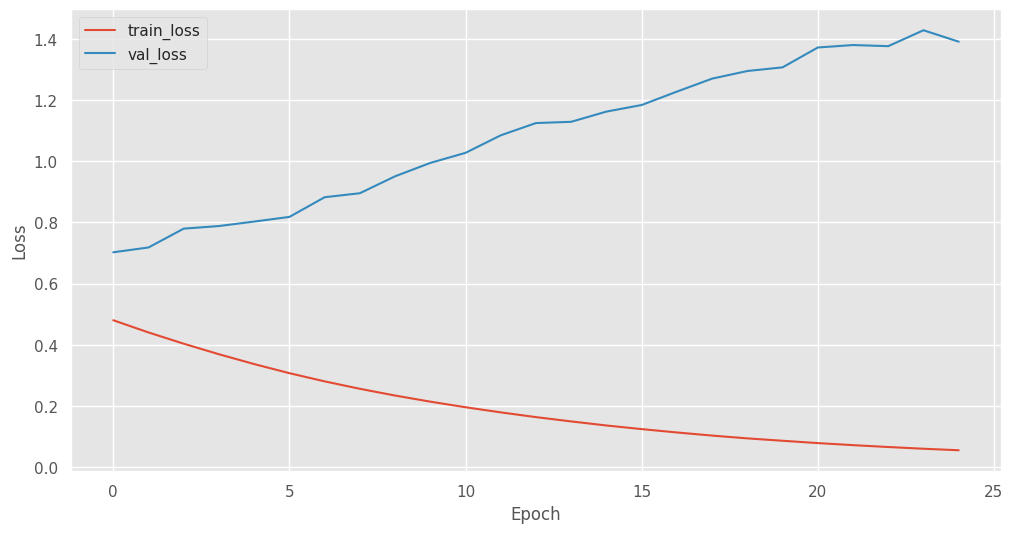

In [74]:
plt.plot(history["loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [76]:
best_val_acc_idx = np.argmin(history['val_loss'])

print(f"After epoch {best_val_acc_idx+1} the model accuracy does not improve")
print(f"Best val accuracy: {history['val_accuracy'][best_val_acc_idx]}")

After epoch 1 the model accuracy does not improve
Best val accuracy: 0.7423136830329895


### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

1543/1543 [==============================] - 3s 2ms/step
Accuracy: 0.736
Accuracy (balanced): 0.725


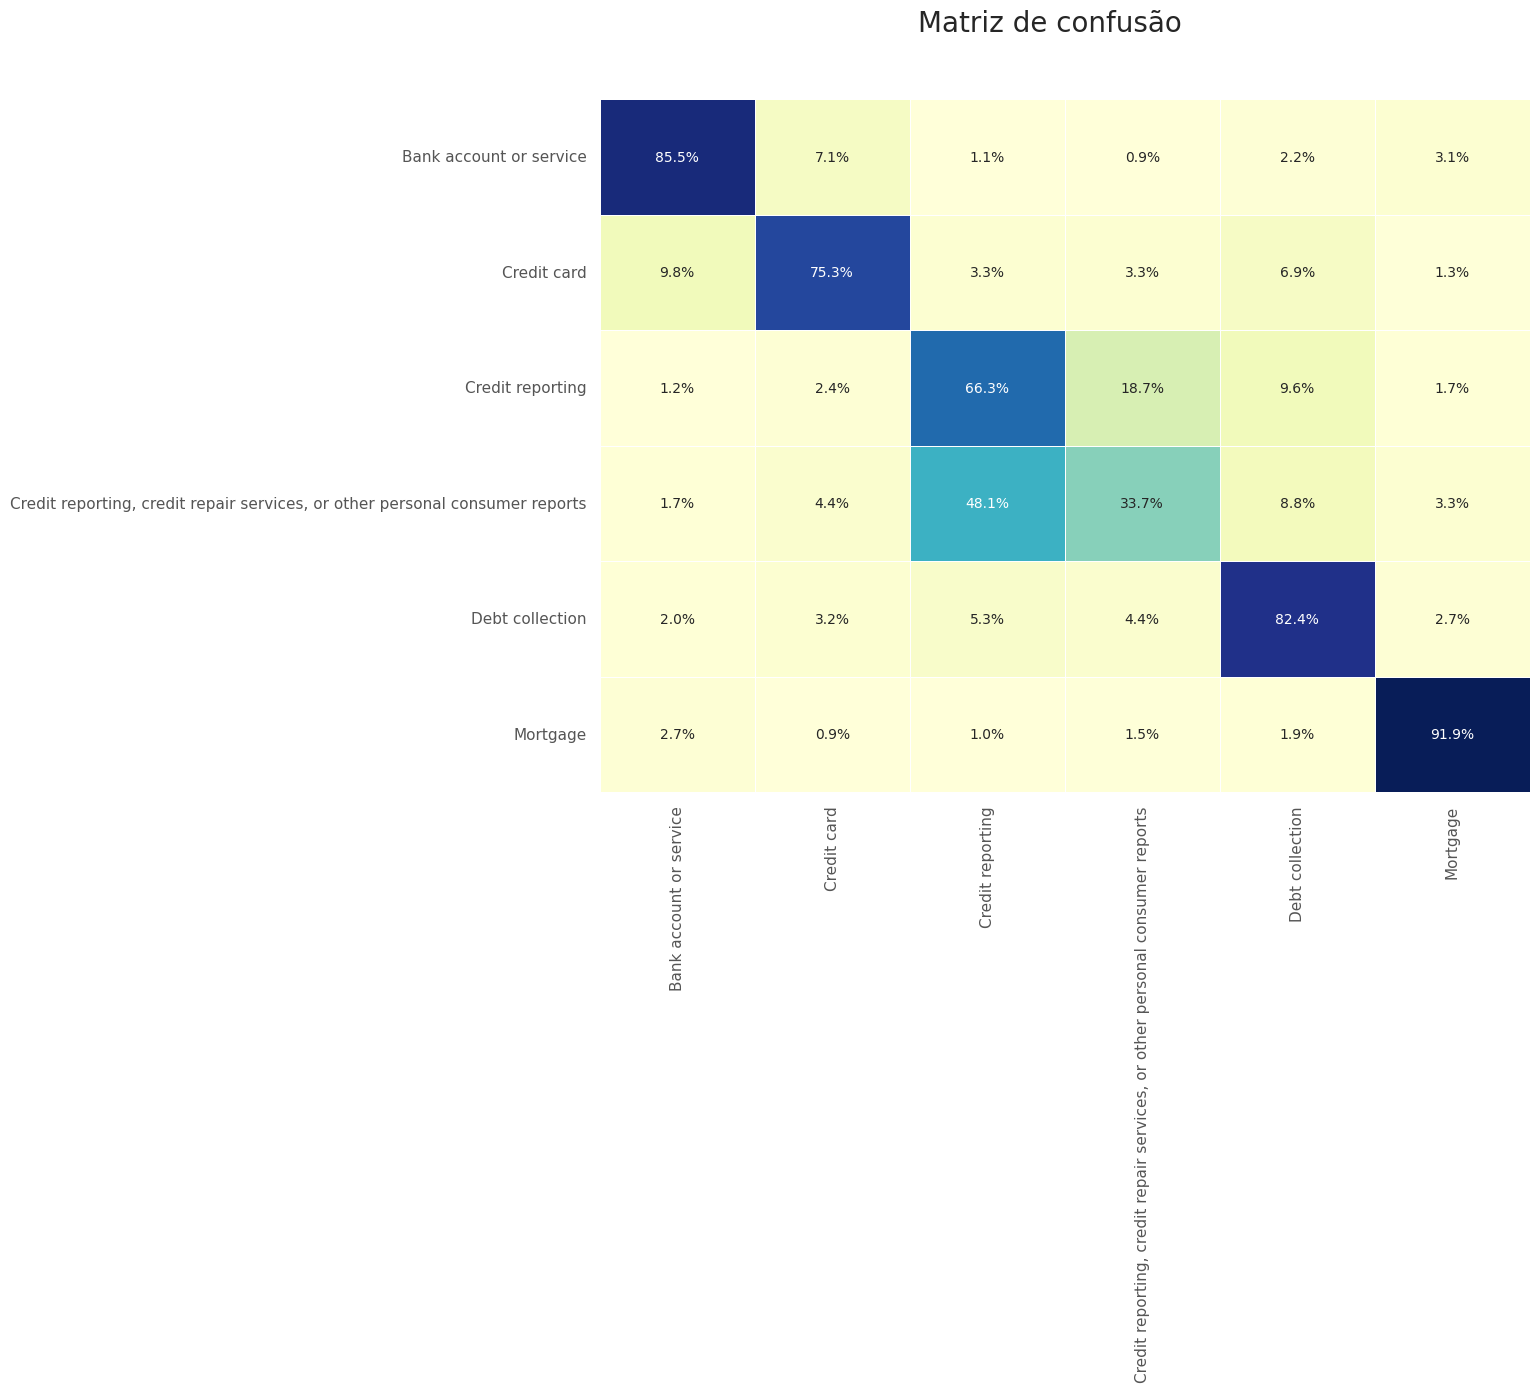

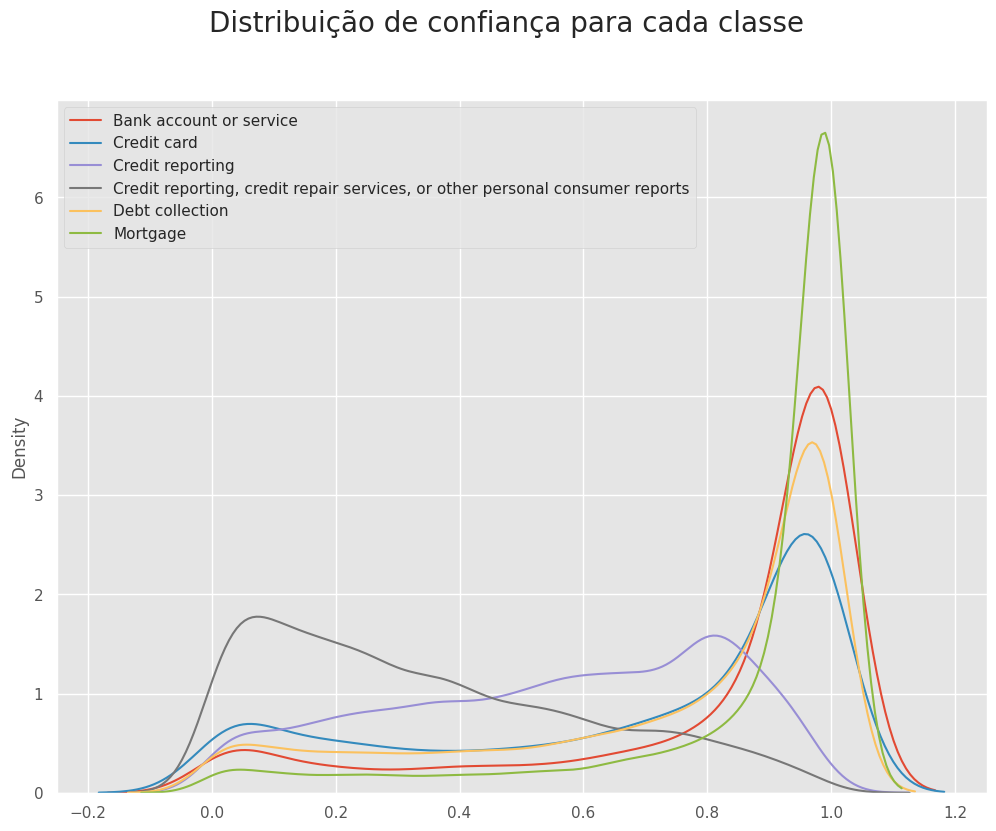

In [77]:
probs = model.predict(x_test.toarray())
predicted_classes = np.argmax(probs, axis=-1)

evaluate(ye_test,
         predicted_classes,
         probs,
         labels=label_enc.classes_)

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [78]:
256/2, 256/4

(128.0, 64.0)

In [90]:
new_model = Sequential()
new_model.add(Dense(512, activation="relu", input_shape=input_shape))
new_model.add(Dense(256, activation="relu"))
new_model.add(Dense(128, activation="relu"))
new_model.add(Dense(64, activation="relu"))
new_model.add(Dense(32, activation="relu"))
new_model.add(Dense(6, activation="softmax"))

sgd = optimizers.SGD(learning_rate=0.01)
new_model.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=["accuracy"])

new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 6)                 198       
                                                                 
Total params: 699558 (2.67 MB)
Trainable params: 69955

**Atividade (1 pt):** treine a nova rede.

In [91]:
new_model.fit(new_train, new_ye_train,
              class_weight=train_class_weights,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(new_val, new_ye_val),
              # callbacks=[checkpoint]
          )

Epoch 1/25
810/810 [==============================] - 5s 5ms/step - loss: 1.2490 - accuracy: 0.5065 - val_loss: 0.8802 - val_accuracy: 0.6681
Epoch 2/25
810/810 [==============================] - 4s 5ms/step - loss: 0.7186 - accuracy: 0.7536 - val_loss: 0.7285 - val_accuracy: 0.7297
Epoch 3/25
810/810 [==============================] - 5s 6ms/step - loss: 0.6088 - accuracy: 0.7940 - val_loss: 0.7252 - val_accuracy: 0.7298
Epoch 4/25
810/810 [==============================] - 4s 5ms/step - loss: 0.5386 - accuracy: 0.8178 - val_loss: 0.7320 - val_accuracy: 0.7305
Epoch 5/25
810/810 [==============================] - 4s 5ms/step - loss: 0.4790 - accuracy: 0.8383 - val_loss: 0.7241 - val_accuracy: 0.7427
Epoch 6/25
810/810 [==============================] - 5s 6ms/step - loss: 0.4211 - accuracy: 0.8564 - val_loss: 0.7475 - val_accuracy: 0.7343
Epoch 7/25
810/810 [==============================] - 4s 5ms/step - loss: 0.3653 - accuracy: 0.8733 - val_loss: 0.9073 - val_accuracy: 0.7262
Epoch 

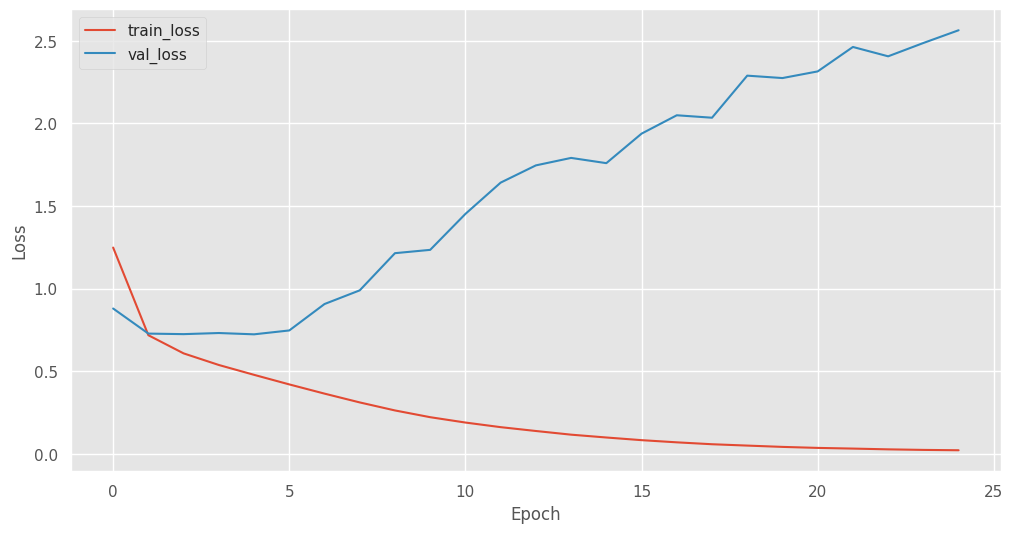

In [92]:
history = new_model.history.history

plt.plot(history["loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [93]:
best_val_acc_idx = np.argmin(history['val_loss'])

print(f"After epoch {best_val_acc_idx+1} the model accuracy does not improve")
print(f"Best val accuracy: {history['val_accuracy'][best_val_acc_idx]}")

After epoch 5 the model accuracy does not improve
Best val accuracy: 0.742747962474823


1543/1543 [==============================] - 3s 2ms/step
Accuracy: 0.713
Accuracy (balanced): 0.692


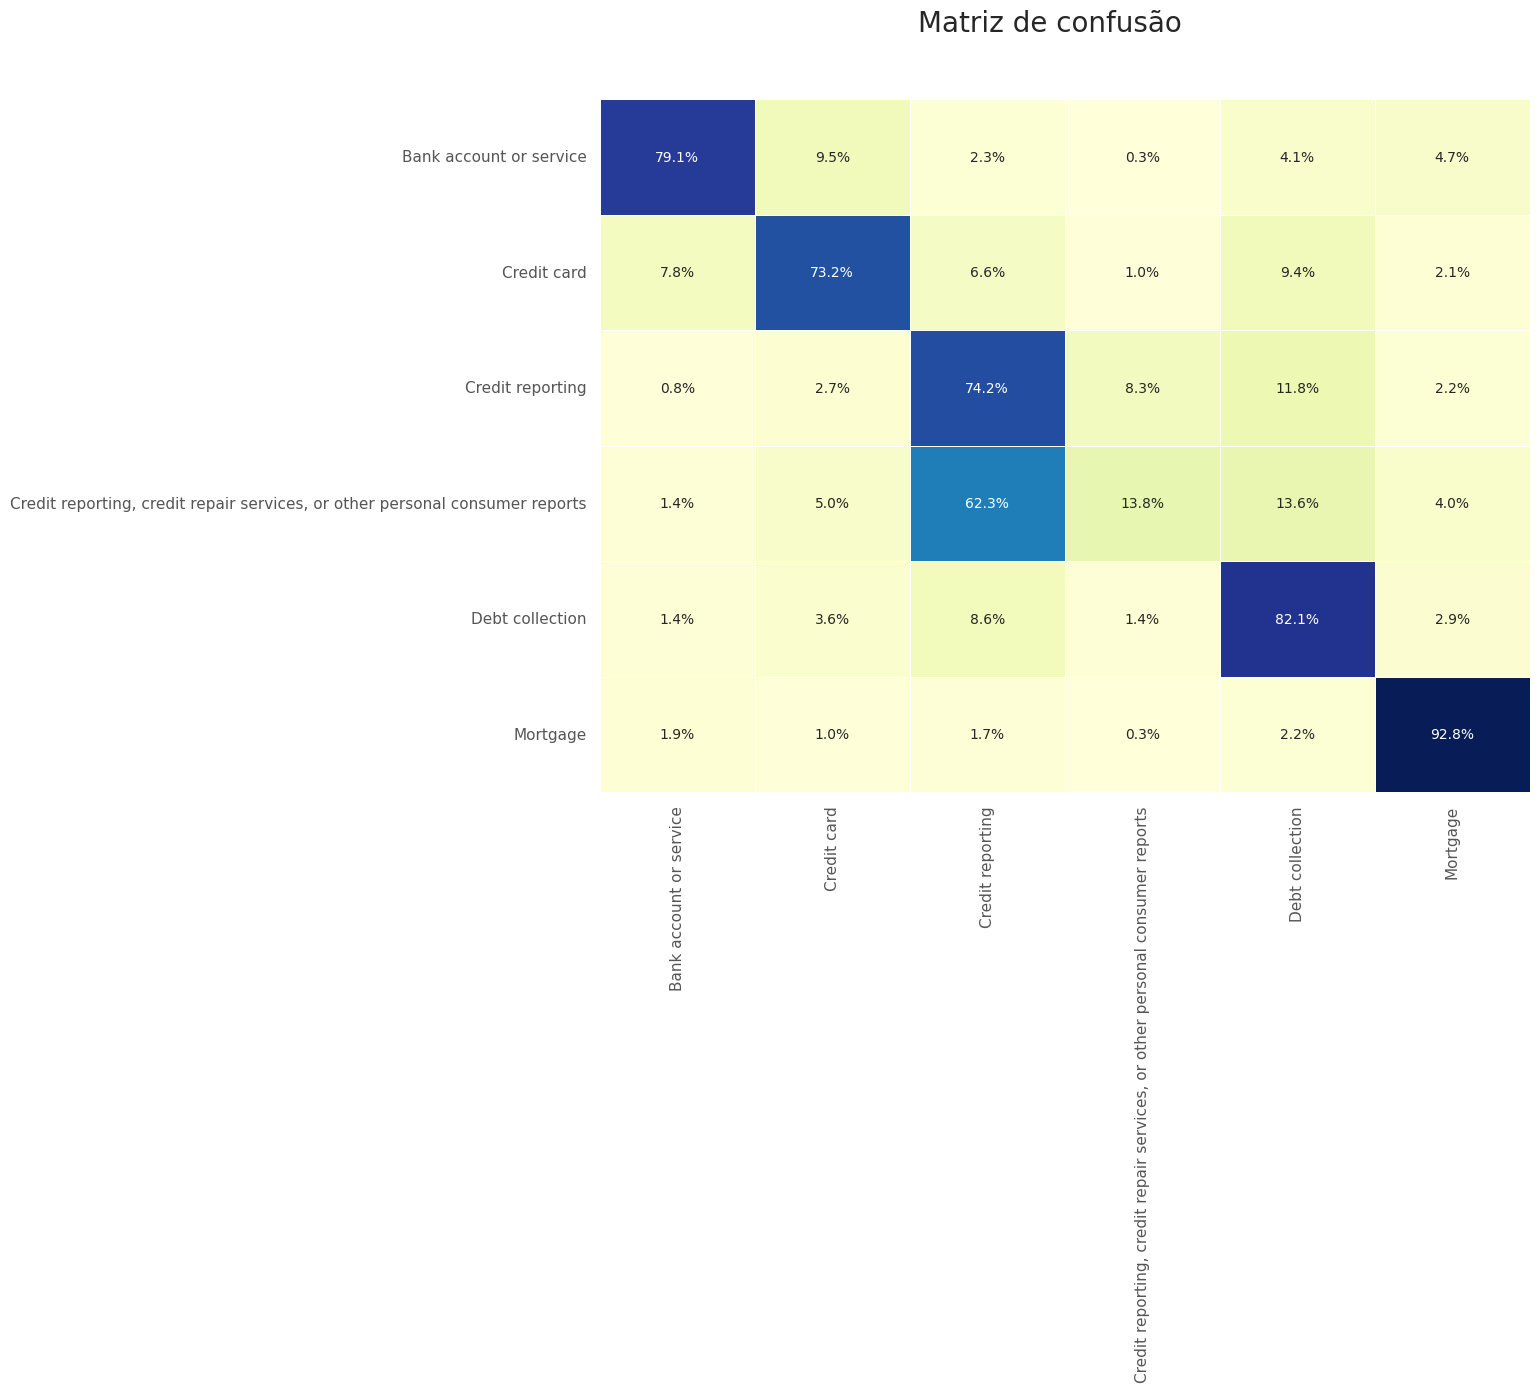

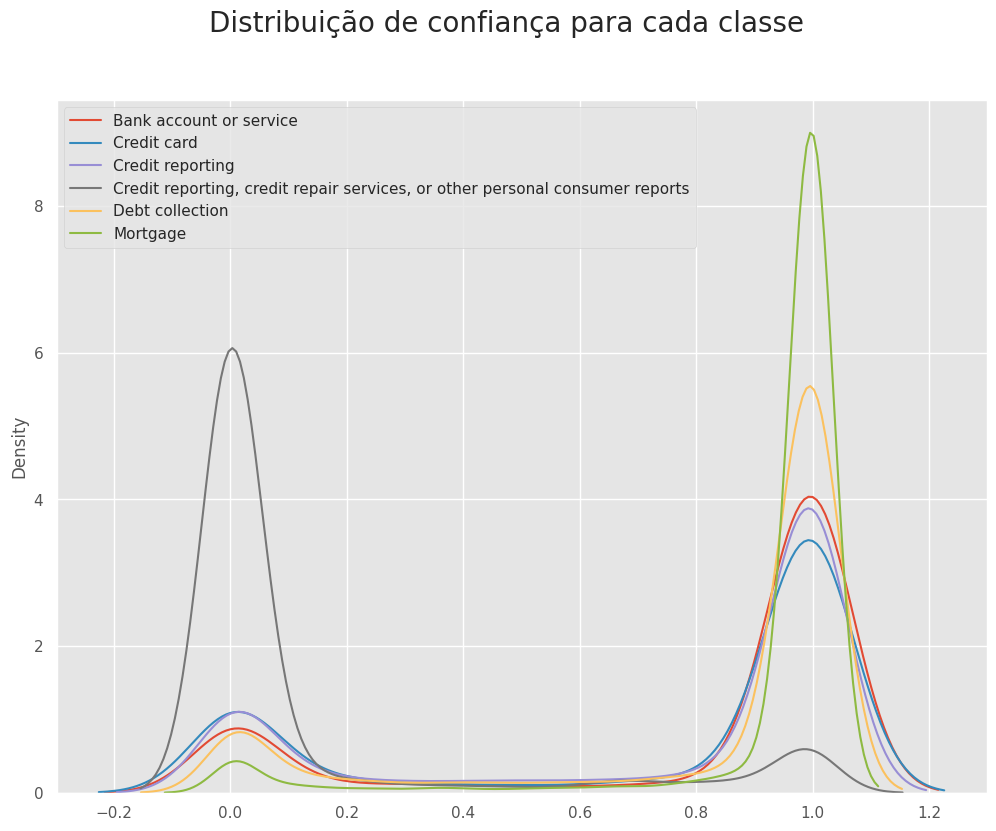

In [95]:
probs = new_model.predict(x_test.toarray())
predicted_classes = np.argmax(probs, axis=-1)

evaluate(ye_test,
         predicted_classes,
         probs,
         labels=label_enc.classes_)

**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [96]:
from keras.layers import Dropout

In [97]:
filepath = os.path.join(base_path, "weights_with_dropout.h5")

print(filepath)

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode="min")

/content/drive/MyDrive/Colab Notebooks/mdc/06_aprendizado_supervisionado_II_inf_0616/test03/weights_with_dropout.h5


In [98]:
new_model_with_dropout = Sequential()
new_model_with_dropout.add(Dense(512, activation="relu", input_shape=input_shape))
new_model_with_dropout.add(Dense(256, activation="relu"))
new_model_with_dropout.add(Dropout(0.5))
new_model_with_dropout.add(Dense(128, activation="relu"))
new_model_with_dropout.add(Dropout(0.5))
new_model_with_dropout.add(Dense(64, activation="relu"))
new_model_with_dropout.add(Dropout(0.5))
new_model_with_dropout.add(Dense(32, activation="relu"))
new_model_with_dropout.add(Dense(6, activation="softmax"))

sgd = optimizers.SGD(learning_rate=0.01)
new_model_with_dropout.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=["accuracy"])

new_model_with_dropout.fit(new_train, new_ye_train,
              class_weight=train_class_weights,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(new_val, new_ye_val),
              callbacks=[checkpoint]
          )

Epoch 1/25
805/810 [============================>.] - ETA: 0s - loss: 1.8335 - accuracy: 0.1868
Epoch 1: val_loss improved from inf to 1.79268, saving model to /content/drive/MyDrive/Colab Notebooks/mdc/06_aprendizado_supervisionado_II_inf_0616/test03/weights_with_dropout.h5
810/810 [==============================] - 6s 6ms/step - loss: 1.8326 - accuracy: 0.1869 - val_loss: 1.7927 - val_accuracy: 0.1813
Epoch 2/25
801/810 [============================>.] - ETA: 0s - loss: 1.7427 - accuracy: 0.2301
Epoch 2: val_loss improved from 1.79268 to 1.64990, saving model to /content/drive/MyDrive/Colab Notebooks/mdc/06_aprendizado_supervisionado_II_inf_0616/test03/weights_with_dropout.h5
810/810 [==============================] - 4s 5ms/step - loss: 1.7419 - accuracy: 0.2308 - val_loss: 1.6499 - val_accuracy: 0.3427
Epoch 3/25
800/810 [============================>.] - ETA: 0s - loss: 1.4663 - accuracy: 0.3735
Epoch 3: val_loss improved from 1.64990 to 1.21318, saving model to /content/drive/MyD

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

**Dos modelos treinados obtivemos os seguintes resultados:**
- Regressão Logística:
  - Accuracy: 0.754
  - Accuracy (balanced): 0.748

- Rede Neural 1:
  - Accuracy: 0.736
  - Accuracy (balanced): 0.725

- Rede Neural 2 (um pouco mais complexa que a primeira):
   - Accuracy: 0.713
   - Accuracy (balanced): 0.692

- Redeu Neural 3 (Rede 2 com camadas de Dropout):
  - Accuracy: 0.712
  - Accuracy (balanced): 0.708

**Podemos notar que de todos os modelos treinados o baseado em Regressão Logística foi o que obteve o melhor resultado em termos de acurácia balanceada.**

**Já entre os modelos baseados em rede neural o melhor modelo em termos de acurácia balanceada foi o primeiro modelo treinado. Tal fato pode estar ligado à complexidade dos modelos subsequentes e também ao overfitting dos modelos. Vale lembrar que treinamos os modelos por $ 25 $ épocas e não fizemos nenhum tipo de condição de parada para evitar o overfitting, mas é algo que poderia ter sido feito utilizando *earling stop*, por exemplo.**

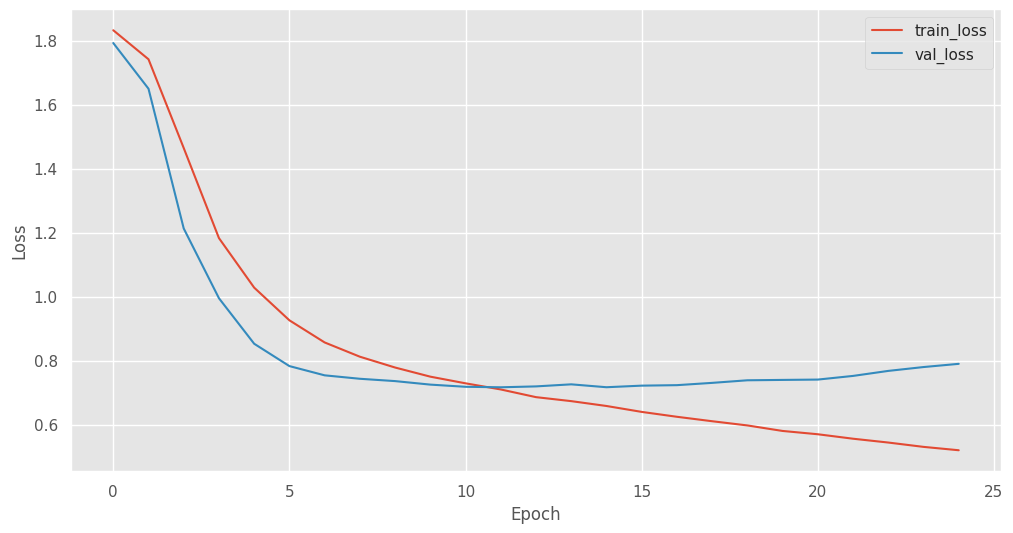

In [99]:
history = new_model_with_dropout.history.history

plt.plot(history["loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [100]:
best_val_acc_idx = np.argmin(history['val_loss'])

print(f"After epoch {best_val_acc_idx+1} the model accuracy does not improve")
print(f"Best val accuracy: {history['val_accuracy'][best_val_acc_idx]}")

After epoch 12 the model accuracy does not improve
Best val accuracy: 0.7384054064750671


1543/1543 [==============================] - 8s 5ms/step
Accuracy: 0.712
Accuracy (balanced): 0.708


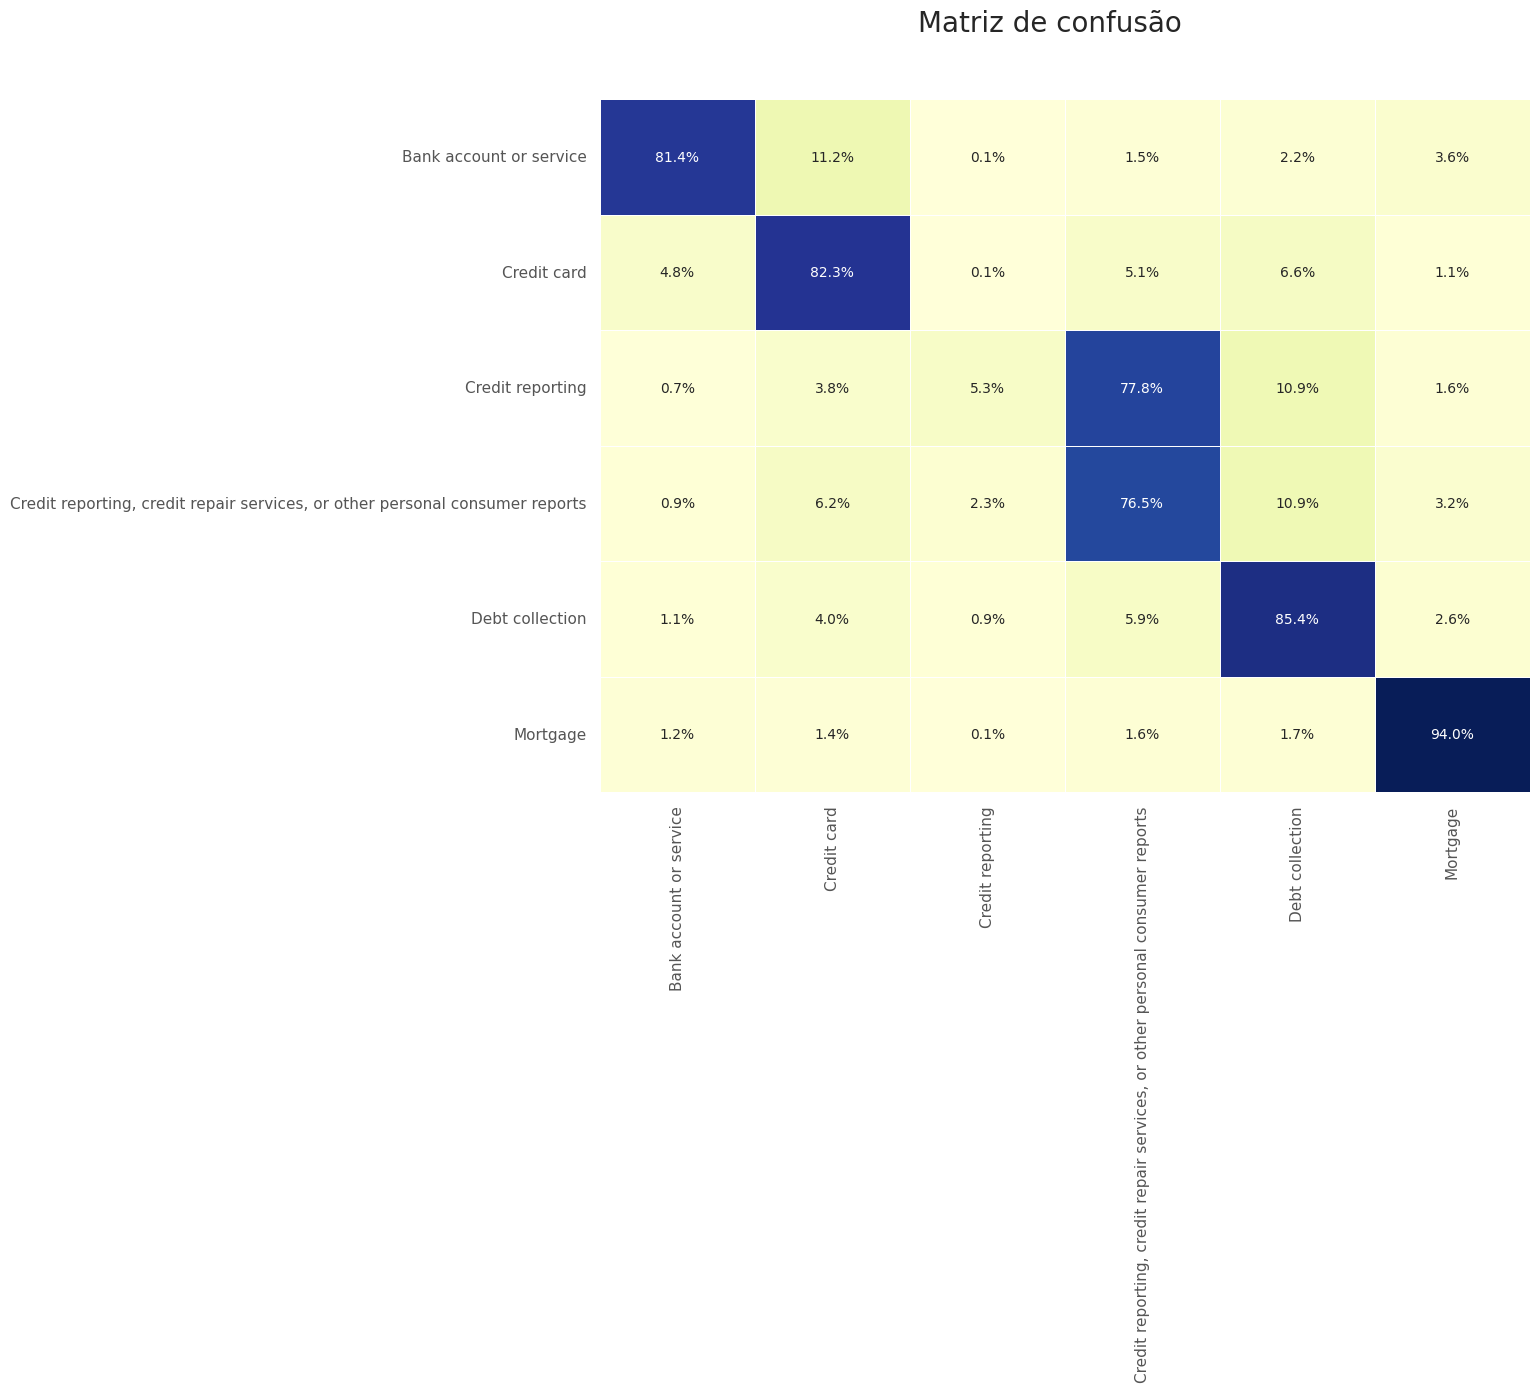

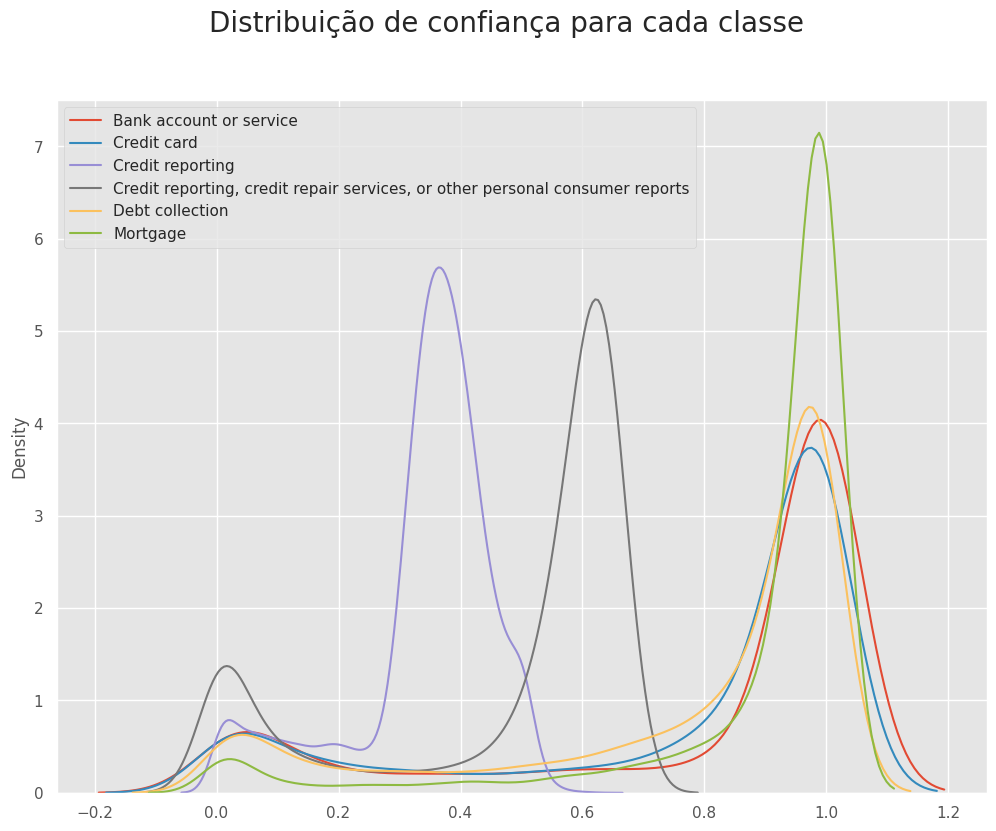

In [101]:
probs = new_model_with_dropout.predict(x_test.toarray())
predicted_classes = np.argmax(probs, axis=-1)

evaluate(ye_test,
         predicted_classes,
         probs,
         labels=label_enc.classes_)